In [6]:
# %%
# Notebook: GBM_Survival_Template.ipynb
# Purpose:
#   1) Read CSV
#   2) Recode variables
#   3) Derive OS / PFS / PRS
#   4) KM plots + multivariable Cox PH model

# %%
# !pip install pandas numpy matplotlib lifelines

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import os
from config import DATA_ROOT

# Make plots look a bit nicer
plt.style.use("default")

# %%
# 1. Read CSV
# --------------------------------------------------------------------
# Set CSV path here:

csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #

df_raw = pd.read_csv(csv_path)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,04/2021,56,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,03/2025,35.3,48.2,12.9,9.2,3.7,9.2
1,2,3,"PGIMER, Chandigarh, India",SRS,08/2018,38,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,09/2024,17.9,74.4,56.5,55.8,0.7,55.8
2,3,1,Dokkyo Medical Universiry,SRS,02/2015,47,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,10/2015,4.8,8.0,3.2,2.8,0.4,2.8
3,4,7,Dokkyo Medical Universiry,SRS,02/2016,74,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,09/2017,9.5,19.6,10.2,9.0,1.1,9.0
4,5,13,Dokkyo Medical Universiry,SRS,06/2017,75,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,11/2020,25.7,40.9,15.2,14.8,0.4,14.8


In [7]:
csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,2021-04-05,56.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,2025-03-21,35.333333,48.200000,12.866667,9.200000,3.666667,9.200000
1,2,3,"PGIMER, Chandigarh, India",SRS,2018-08-10,38.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,2024-09-18,17.900000,74.366667,56.466667,55.766667,0.700000,55.766667
2,3,1,Dokkyo Medical Universiry,SRS,2015-02-23,47.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,2015-10-22,4.800000,8.033333,3.233333,2.833333,0.400000,2.833333
3,4,7,Dokkyo Medical Universiry,SRS,2016-02-05,74.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,2017-09-16,9.466667,19.633333,10.166667,9.033333,1.133333,9.033333
4,5,13,Dokkyo Medical Universiry,SRS,2017-06-28,75.0,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,2020-11-06,25.733333,40.900000,15.166667,14.766667,0.400000,14.766667


In [8]:
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"

# read in variables
df = df_raw[time_points + variables].copy()
for col in time_points:
    # check if there is any missing data
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
# add a new column to calculate survival time
df["Survival Time (days)"] = (pd.to_datetime(df["Date of death or last follow-up"]) - pd.to_datetime(df["Date of first recurrence per RANO (date of MRI)"])).dt.days

for col in variables:
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
    # if missing, fill with median or mode
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# read a survival event column
df["Event Observed"] = df_raw["Death (1: yes / 0: no)"].astype(bool)
missing_count = df["Event Observed"].isnull().sum()
print(f"Missing values in 'Event Observed': {missing_count}")

# survival time prediction
df = df[df["Survival Time (days)"] >= 0]  # remove negative survival times
print("Processed shape:", df.shape)

# use survivaltree to predict survival


df.head()



Missing values in 'Date of first recurrence per RANO (date of MRI)': 0
Missing values in 'Date of death or last follow-up': 0
Missing values in 'Age at diagnosis': 0
Missing values in 'KPS before SRS or re-RT for Recurrence': 5
Missing values in 'Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)': 16
Missing values in 'SRS Dose (Gy)': 1
Missing values in 'Event Observed': 0
Processed shape: (272, 8)


/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_26127/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_26127/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,Date of first recurrence per RANO (date of MRI),Date of death or last follow-up,Age at diagnosis,KPS before SRS or re-RT for Recurrence,Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),SRS Dose (Gy),Survival Time (days),Event Observed
0,2024-02-29,2025-03-21,56.0,80.0,3.000,16.0,386,False
1,2020-01-29,2024-09-18,38.0,90.0,1.020,10.0,1694,False
2,2015-07-17,2015-10-22,47.0,80.0,4.626,20.0,97,True
3,2016-11-15,2017-09-16,74.0,80.0,1.509,20.0,305,True
4,2019-08-09,2020-11-06,75.0,90.0,2.414,20.0,455,False


In [9]:
'''
create a model to predictive PRS(post-recurrence survival) in patients, the PRS survival time is defined as the time from recurrence to death
 recurrence: "Date of first recurrence per RANO (date of MRI)", death: "Date of death or last follow-up". variables can be used "Age at diagnosis,
KPS before SRS or re-RT for Recurrence,
Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),
SRS Dose (Gy)"
'''

'\ncreate a model to predictive PRS(post-recurrence survival) in patients, the PRS survival time is defined as the time from recurrence to death\n recurrence: "Date of first recurrence per RANO (date of MRI)", death: "Date of death or last follow-up". variables can be used "Age at diagnosis,\nKPS before SRS or re-RT for Recurrence,\nPre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),\nSRS Dose (Gy)"\n'

In [10]:
from sksurv.util import Surv
from sksurv.tree import SurvivalTree
from sksurv.metrics import concordance_index_censored

#
# Prepare data for survival tree
y_structured = Surv.from_dataframe("Event Observed", "Survival Time (days)", df)
X = df[variables]
# Fit survival tree
surv_tree = SurvivalTree(max_depth=2, min_samples_split=6)
surv_tree.fit(X, y_structured)
# Predict risk scores
risk_scores = -surv_tree.predict(X)  # negative because higher risk should correspond to lower survival



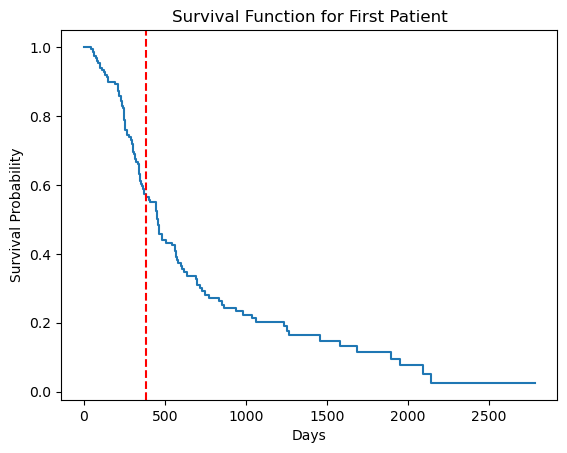

In [15]:
# plot survival curve for the first patient
surv_func = surv_tree.predict_survival_function(X.iloc[[0]])
for fn in surv_func:
    plt.step(fn.x, fn.y, where="post")
# plot actual survival curve
actual_times = df.iloc[0]["Survival Time (days)"]
actual_event = df.iloc[0]["Event Observed"]
plt.axvline(x=actual_times, color="r", linestyle="--", label="Actual Survival Time")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.title("Survival Function for First Patient")
plt.show()

Concordance Index: 0.3936749739039666
Patient features:
    Age at diagnosis  KPS before SRS or re-RT for Recurrence  \
0              56.0                                    80.0   

   Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)  \
0                                                3.0                    

   SRS Dose (Gy)  
0           16.0  
(False, 386.0)
Patient features:
    Age at diagnosis  KPS before SRS or re-RT for Recurrence  \
1              38.0                                    90.0   

   Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)  \
1                                               1.02                    

   SRS Dose (Gy)  
1           10.0  
(False, 1694.0)
[StepFunction(x=array([   0.,   32.,   34.,   38.,   43.,   45.,   50.,   57.,   62.,
          63.,   65.,   66.,   74.,   76.,   80.,   81.,   86.,   88.,
          89.,   91.,   97.,  102.,  111.,  116.,  117.,  119.,  121.,
         124.,  125.,  126.,  127.,  131.

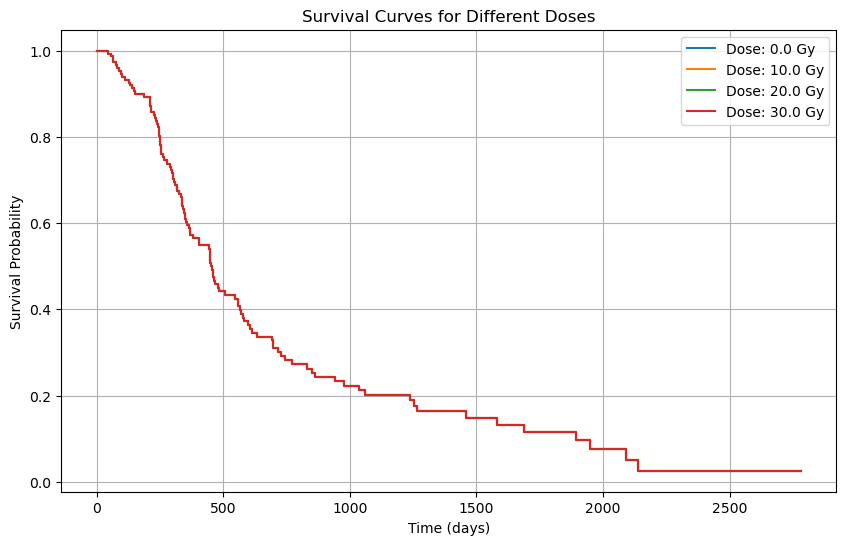

In [12]:


# Evaluate concordance index
c_index = concordance_index_censored(df["Event Observed"], df["Survival Time (days)"], risk_scores)
print("Concordance Index:", c_index[0]) 

# predict survival function for a given patient and dose
def best_dose_by_survival_at_t(surv_tree, x0, doses, t_star):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["SRS Dose (Gy)"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        print(surv_func)
        S_t = surv_func[0](t_star)  # survival probability at time t_star
        S.append(S_t)
        print(S_t)
    S = np.array(S)
    best_dose = doses[np.argmax(S)]
    return best_dose, S.max(), S

# predict survival time based on different doses, draw survival curve
def best_dose_by_survival_curve(surv_tree, x0, doses):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["SRS Dose (Gy)"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        S.append(surv_func[0])
    return doses, S
# Example usage:
# dose grid (choose clinically valid bounds/step)
doses = np.linspace(0, 30, 61)  # 0..70 Gy in 0.5 Gy steps


x0 = X.iloc[[0]].copy()
print("Patient features:\n", x0)
print(y_structured[0])
x1 = X.iloc[[1]].copy()
print("Patient features:\n", x1)
print(y_structured[1])
best_dose, best_survival, survival_all = best_dose_by_survival_at_t(surv_tree, x0, doses, t_star=180)
print("Best Dose:", best_dose)
print("Best Survival Probability at 2 years:", best_survival)
# Draw survival curves for different doses
doses, survival_funcs = best_dose_by_survival_curve(surv_tree, x0, doses)
plt.figure(figsize=(10, 6))
for i, d in enumerate(doses[::20]):  # plot every 20th dose
    plt.step(survival_funcs[i*20].x, survival_funcs[i*20].y, where="post", label=f"Dose: {d} Gy")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Survival Curves for Different Doses")
plt.legend()
plt.grid()
plt.show()
